## GENEROWANIE NAJKRÓTSZYCH TRAS

W celu obliczenia najkrótszej trasy możliwej do pokonania przez pojazd, poruszający się po zadanym zakręcie, skorzystamy z funkcji generującej 1000 losowych zakrętów. Jest ona złożona z pętli, która przechodzi po kolejnych elementach, losowowo wygenerowanych tablic, zmiennych mieszczących się w zadeklarowanym przedziale. Tutaj ze względu na ogarniczenia, aby żadna wygenerowana droga nie wychodziła poza trasę, eliminujemy trasy które nie mieszczą się w ograniczeniach (ograniczenie_g oraz ograniczenie_d).

In [1]:
using Distributions
using Plots
using QuadGK
using ForwardDiff
using DataFrames

tab3 = Array{Function}(undef, 0)
tab4 = Array{Function}(undef, 0)
tab_dlugosci_luku = []
tab_dlugosci_luku_2 = []
x3 = []
y = []
r = []
al = []
dl = []

ograniczenie_d = 10 # promien krótszego łuku
ograniczenie_g = 20 # promien dluzszego luku
punktp_sx = 15 # z tego punktu start (x = 15)
punktp_sy = 0 # z tego punktu start (y =0)

    # Tworzenie trasy
f(x) = ograniczenie_g*sin(x)
g(x) = ograniczenie_g*cos(x)
h(x) = ograniczenie_d*sin(x)
j(x) = ograniczenie_d*cos(x)
tab1 = [g, j]
tab2 = [f, h]
k = rand(Uniform(-100, 0), 200)
c = rand(Uniform(-100, 100), 200)

function generowanie_tras(ograniczenie_d, ograniczenie_g)
    for t1 in k
        for t2 in c
            x2 = t1 #współrzędna x środka okregu wygenerowanego
            y3 = t2 #współrzedna y wygenerowanego okregu
            r1 = sqrt((x2-15)^2 + (y3)^2) # promien danego okregu
            odl = sqrt((x2)^2 + (y3)^2) # odl miedzy punktem (0,0), a srodkiem danego okregu
            y0 = y3 + sqrt((r1)^2 - (x2)^2) # punkt przeciecia z osia OY (0, y0)
            dluod = sqrt(15^2 + y0^2) # odl miedzy punktem (15,0) a (0,y0)
            if abs(r1-ograniczenie_d-0.25) > odl && y0 < ograniczenie_g-0.25 && r1<50 # ograniczenia
                al1 = acos(1-((dluod^2)/(2*r1^2))) # kąt tworzony przez punkty: (0,y0), sr danego okregu i (15,0) 
                dl1 = al1*r1  # dlugosc luku okregu miedzy (0,y0) i (15,0)
                push!(y, y3)
                push!(x3, x2)
                push!(r, r1)
                push!(al, al1)
                push!(dl, dl1)
            end
        end
    end

    for s in 1:length(r)
        p(x) = r[s]*sin(x) + y[s]
        q(x) = r[s]*cos(x) + x3[s]
        push!(tab3, q)
        push!(tab4, p)
    end
end
generowanie_tras(ograniczenie_d, ograniczenie_g)

## WYGENEROWANIE TRAS NA WYKRESIE

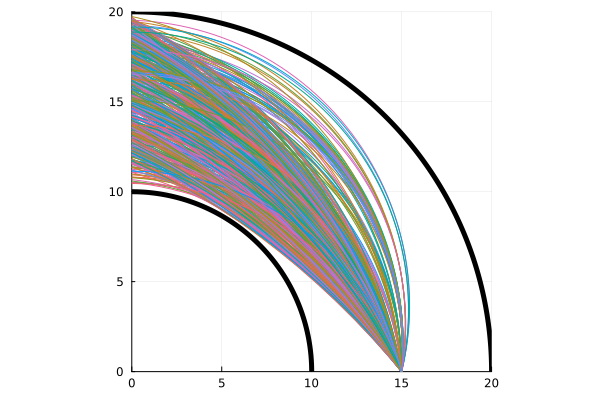

In [2]:
plot(tab3, tab4, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, 20),
     ylim=(0, 20), legend=false)
plot!(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## OBLICZANIE DROGI JAKĄ POKONA POJAZD

### WYNIK OCZEKIWANY

Analizując podstawowy wzór fizyczny jakim jest: $\displaystyle s=\int \operatorname{d}s=\int v(t)\operatorname{d}t=\int r(\theta)\operatorname{d}\theta$, jesteśmy w stanie za pomocą badania zmiany kąta w konkretnym punkcie obliczyć optymalną drogę jaką powinien pokonać bolid aby ta była jak najbardziej optymalna. Tutaj dodatkowo posiłkując się spiralą Eulera jesteśmy w stanie wyznaczyć dwa koła będące naszą „trasą”, inaczej mówiąc jej ograniczeniami (jak na zalączonym obrazku). 
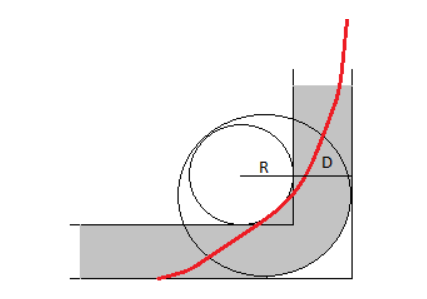

Jest to o tyle dogodne dla nas narzędzie iż dzięki takiemu przybliżeniu jesteśmy w stanie skorzystać z przekształconego wzoru i zamiast zmian kąta pod jakim pojazd się ustawia do trasy, które musiałyby bazować na dużych tablicach macierzowych za względu na pary punktów, korzystamy ze stałych promieni oraz danego przekształcenia: 
\begin{equation*}
\displaystyle s=\int \sqrt{\left(r_{1}+\left(\frac{r_{2}-r_{1}}{s_{1}}\right)\cdot s\right) \cdot \left(\frac{1}{\mu \cdot g}\right)}\operatorname{d}\!s.
\end{equation*}
Za pomocą tego wzoru zaimplementowanego do Julii sprawdzimy najkrótszą możliwą do pokonania trasę i będzie ona wartością bazową ze względu na jej stałość. 

### FUNKCJA PREZENTUJĄCA ZAKRĘT

In [3]:
function integrand(s::Float64, r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64)
    u = r1 + (r2 - r1) / s1 * s
    sqrt(u/m*g)
end
a = 0.0
b = pi/2
max_order = 1000

1000

#### METODA PROSTOKĄTÓW

W tej metodzie korzystamy z definicji całki oznaczonej Riemanna, w której wartość całki interpretowana jest jako suma pól obszarów pod wykresem krzywej w zadanym przedziale całkowania $[x_{p}, x_{k}]$. Następnie sumę tę przybliżamy przy pomocy sumy pól odpowiednio dobranych prostokątów.

Przedział całkowania $[x_{p}, x_{k}]$ dzielimy na $n$ równo odległych punktów $x_{1}, x_{2}, ..., x_{n},$ jak na załączonej grafice.
![metoda_prostokątów.png](images\prostokaty.png)
Następnie obliczamy odległości między prostokątami
\begin{equation*}
\Delta x = \frac{x_{k}-x_{p}}{n}
\end{equation*}
Dla każdego wyznaczonego w ten sposób punktu obliczamy wartość funkcji $f(x).$
Następnie obliczamy sumę iloczynów wyznaczonych wartości funkcji przez odległość $\Delta x$ między dwoma sąsiednimi punktami
\begin{equation*}
S = f_{1}\cdot\Delta x + f_{2}\cdot\Delta x + ... + f_{n}\cdot\Delta x = \Delta x \cdot (f_{1}+f_{2}+...+f_{n})
\end{equation*}

In [4]:
function integrate_rectangles(f, a, b, n)
    delta_x = (b - a) / n
    sum = 0.0

    for i in 0:n-1
        x = a + (i + 0.5) * delta_x
        sum += f(x)
    end
    result = delta_x * sum
    result
end

P = integrate_rectangles(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.81292342039796

#### METODA TRAPEZÓW

Metoda ta jest podobna do poprzedniej z tym, że zamiast prostokątów używamy trapezów o wysokościach $\Delta x$ i podstawach równych odpowiednim wartościom funkcji $f(x)$ w punktach krańcowych.
![metoda_trapezów.png](images\trapezy.png)

In [5]:
function integrate_trapezoids(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64, n::Int64)
    delta_s = (b - a) / n
    sum = 0.0
    s = a
    for i in 1:n-1
        u = r1 + (r2 - r1) / s1 * s
        sum += integrand(s, r1, r2, s1, m, g)
        s += delta_s
    end
    result = delta_s * ((integrand(a, r1, r2, s1, m, g) + integrand(b, r1, r2, s1, m, g)) / 2.0 + sum)
    result
end
T = integrate_trapezoids(10.0, 20.0, 1.0, 1.0, 10.0, a, b, max_order)

20.803452817123272

#### METODA SIMPSONA

Metoda ta jest podobna do poprzednich z tym, że do przybliżenia całki stosujemy parabolę.
![metoda_simpsona.jpg](images\simpson.jpg)

In [6]:
function integrate_simpson(f, a, b, n)
    delta_x = (b - a) / n
    sum = f(a) + f(b)
    for i in 1:n-1
        x = a + i * delta_x
        if iseven(i)
            sum += 2 * f(x)
        else
            sum += 4 * f(x)
        end
    end
    result = delta_x / 3 * sum
    result
end

S = integrate_simpson(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.812923226956855

#### PRÓBA KONTROLNA (ZA POMOCĄ PAKIETU WBUDOWANEGO QUADGK)

In [8]:
function integrate(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64)
    f(s) = integrand(s, r1, r2, s1, m, g)
    Q, err=quadgk(f, a, b)
    Q, err
end
W = (integrate(10.0, 20.0, 1.0, 1.0, 10.0, a, b))

(20.812923226956958, 2.063025306142663e-10)

#### ZESTAWIENIE TABELARYCZNE OBLICZEŃ DOTYCZĄCYCH DROGI ZE STAŁEGO WZORU (PORÓWNANIE METOD)

In [9]:
tabela = DataFrame(PROSTOKĄTÓW = P, TRAPEZÓW = T, SIMPSONA = S, WBUDOWANA = W[1])
tabela

Row,PROSTOKĄTÓW,TRAPEZÓW,SIMPSONA,WBUDOWANA
,Float64,Float64,Float64,Float64
1,20.8129,20.8035,20.8129,20.8129


### OBLICZANIE DŁUGOŚCI WYGENEROWANYCH TRAS

#### FUNKCJA RIEMANNA

Suma Riemanna jest jednym z najprostszych do zrozumienia przybliżeń pola powierzchni pod krzywą. Jej podstawową ideą jest to, że przedział [a, b] jest podzielony przez punkty $a=x_{0}<x_{1}<x_{2}<...<x_{n}=b$ i teren pod $f(x)$ jest aproksymowany przez prostokąt z podstawą $x_{i}+1 - x_{i}$ i wysokość podaną jako $f(s)$, gdzie s to jakiś punkt z przedziału $[x_{i}, x_{i+1}]$. Typowe wybory to lewy punkt lub prawy interwału lub wartośi x, która minimalizuje lub maksymalizuje przez interwał. Rysunek przedstawia te cztery opcje dla pewnej przykładowej funkcji. Dla funkcji całkowalnej Riemanna, takiej jak funkcja ciągła na zadanym przedziale, każda z opcji da taką samą wartość, do jakiej zmniejszy się siatka partycji.


W naszym kodzie zaimplementowaliśmy funkcję do obliczenia całki metodą Riemanna. W omawianym kodzie danymi wejściowymi funkcji będą:
- funkcja,
- wartość początkowa i końcowa interwału oraz
- liczba równych podprzedziałów.

Ponadto dopuszczamy możliwość zastosowania różnych metod aproksymacji obszaru w podprzedziale. Wyróżniamy tu funkcje w których skorzystamy z:
- prostokąta z lewym końcem do określenia wysokości (method="left" )
- prostokąta z prawym końcem do określenia wysokości (method="right" )
- trapezu utworzonego przez połączenie lewego i prawego punktu końcowego (method="trapezoid" )
- wielomianu o stopniu dwa, który przechodzi przez lewy i prawy punkt końcowy oraz punkt środkowy ( method="simpsons")

In [10]:
function riemann(f, a::Real, b::Real, n::Int; method="right")
  if method == "right"
     meth = (f,l,r) -> f(r) * (r-l)
  elseif method == "left"
     meth= (f,l,r) -> f(l) * (r-l)
  elseif method == "trapezoid"
     meth = (f,l,r) -> (1/2) * (f(l) + f(r)) * (r-l)
  elseif method == "simpsons"
     meth = (f,l,r) -> (1/6) * (f(l) + 4*(f((l+r)/2)) + f(r)) * (r-l)
  end

  xs = range(a, b, length=n+1)
  lrs = zip(Iterators.take(xs, n), Iterators.rest(xs, 1))
  sum(meth(f, l, r) for (l,r) in lrs)
end

riemann (generic function with 1 method)

#### I SPOSÓB

Pierwszy sposób jaki uwzględnimy w naszym projekcie będzie bazował na wzorze: 
\begin{equation*}
L = 2\pi r \left(\frac{\theta}{360^{\circ}}\right).
\end{equation*}
Zawarty jest on w pętli kodu, gdzie za pomocą ... obliczamy kąt $\theta$ Wszystkie wartości z tych obliczeń zostają dodane do tablicy dl dzięki czmu mamy zestawienie poszczególnych długości.

In [11]:
print(argmin(dl), "\n") # numer argumentu o najkrotszym luku
print(dl[argmin(dl)])
dl

46
19.034659127759557

557-element Vector{Any}:
 24.082792523467422
 22.35456344256184
 24.357169581920243
 19.470235230715925
 21.298972738860748
 20.219270605499396
 24.514827033746133
 24.43064445777193
 24.209213803237976
 22.58457448763138
 22.038517326186152
 23.412766059791398
 24.49771175080452
  ⋮
 19.259832424783117
 19.852425637961005
 19.790591585616905
 24.280343051998766
 22.534424056038667
 24.556989145397765
 19.604241493745683
 21.46472482176411
 20.36751282253343
 24.71588958186594
 24.63104874305012
 24.40782672439261

#### II SPOSÓB

In [12]:
suma_kwadratow_left = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="left")
    push!(suma_kwadratow_left, dlugosc_luku)
end
# suma_kwadratow_left

suma_kwadratow_right = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="right")
    push!(suma_kwadratow_right, dlugosc_luku)
end
# suma_kwadratow_right

suma_kwadratow_trapezoid = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="trapezoid")
    push!(suma_kwadratow_trapezoid, dlugosc_luku)
end
# suma_kwadratow_trapezoid

suma_kwadratow_simpsons = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="simpsons")
    push!(suma_kwadratow_simpsons, dlugosc_luku)
end
# suma_kwadratow_simpsons

suma_kwadratow_wbudowana = []
for s in 1:length(r)
    dlugosc_luku = quadgk(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s])[1]
    push!(suma_kwadratow_wbudowana, dlugosc_luku)
end
# suma_kwadratow_wbudowana

In [13]:
suma = DataFrame(RIGHT = suma_kwadratow_right, LEFT = suma_kwadratow_left, TRAPEZÓW = suma_kwadratow_trapezoid, SIMPSONA = suma_kwadratow_simpsons, WBUDOWANA = suma_kwadratow_wbudowana)
suma

Row,RIGHT,LEFT,TRAPEZÓW,SIMPSONA,WBUDOWANA
,Any,Any,Any,Any,Any
1,24.0828,24.0828,24.0828,24.0828,24.0828
2,22.3546,22.3546,22.3546,22.3546,22.3546
3,24.3572,24.3572,24.3572,24.3572,24.3572
4,19.4702,19.4702,19.4702,19.4702,19.4702
5,21.299,21.299,21.299,21.299,21.299
6,20.2193,20.2193,20.2193,20.2193,20.2193
7,24.5148,24.5148,24.5148,24.5148,24.5148
8,24.4306,24.4306,24.4306,24.4306,24.4306
9,24.2092,24.2092,24.2092,24.2092,24.2092


#### III SPOSÓB

Kolejną metodą dzięki której będziemy mogli porównać i tym samym zweryfikować wyniki będzie program który również będzie bazował na całce oznaczonej. Natomiast tym razem będzie to wzór znany w analizie jako wzór na długość krzywej, w naszym przypadku łuku. 
\begin{equation*}
\displaystyle L=\int_{a}^{b} \sqrt{1+[f'(x)]^{2}}\operatorname{d}\!x.
\end{equation*}
W widocznym wzorze wykorzystując wcześniej wygenerowane losowe trasy, oraz za pomocą zaimplementowanej przez nas funkcji „wielomian”, wyznaczamy wzory wielomianów które będą reprezentować trasę. Następnie wyznaczamy pochodną odpowiedniego wielomianu, tutaj domyślnie stopnia dwa, oraz obliczymy całkę oznaczoną z pierwiastka z sumy jedynki oraz kwadratu pochodnej funkcji. Odnosząc się do samej funkcji „wielomian” bazuje ona na wartościach pdpowiadających początkowi i końcowi trasy oraz wyznaczeniu prostej przechodzącej przez te punkty. Następnie program generuje łuk oraz wyznacza n punktów po których w dalszej części będzie przechodziła interacja aby z wykorzystaniem macierzy u nas w programie "A", wyznaczyć współczynniki wielomianu.

#### FUNKCJA WIELOMIAN

In [14]:
using Polynomials
function wielomian(r)
    # Wyznaczenie punktów końcowych łuku
    x1, y1 = r, 0
    x2, y2 = 0, r

    # Wyznaczenie równania prostej przechodzącej przez punkty (x1, y1) i (x2, y2)
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # Wyznaczenie punktów przecięcia okręgu i prostej
    a = m^2 + 1
    b = 2 * m * b
    c = b^2 / 4 - r^2
    delta = sqrt(b^2 - 4 * a * c)
    x_1 = (-b + delta) / (2 * a)
    #x_2 = (-b - delta) / (2 * a)
    y_1 = m * x_1 + b
    #y_2 = m * x_2 + b

    # Wyznaczenie długości łuku między punktem (x1, y1) a punktem przecięcia (x_1, y_1)
    d = sqrt((x_1 - x1)^2 + (y_1 - y1)^2)

    # Wyznaczenie liczby punktów na łuku
    n = Int(round((d / r) * pi / 2))

    # Wyznaczenie punktów na łuku
    pary_punktow_luku = [(r * cos(t), r * sin(t)) for t in range(0, stop=pi/2, length=n)]

    # Wyznaczenie stopnia wielomianu
    stopien = div(n, 2)

    # Wyznaczenie współczynników wielomianu
    xs = [point[1] for point in pary_punktow_luku]
    ys = [point[2] for point in pary_punktow_luku]
    A = ones(n, stopien+1)
    for i=1:n
        for j=2:(stopien+1)
            A[i,j] = A[i,j-1] * xs[i]
        end
    end
    punkty = (A' * A) \ (A' * ys)
    return punkty
end

wielomian (generic function with 1 method)

In [15]:
wielomiany = []
for i in r
    miara = wielomian(i)
    push!(wielomiany, Polynomial([miara[1], miara[2], miara[3]]))  # Utwórz obiekt wielomianu za pomocą Polynomial
    n = 1000  # liczba punktów
end

wyniki_right = []
wyniki_left = []
wyniki_trapezoid = []
wyniki_simpsons = []

for i in wielomiany
    f_poly = Polynomial(i)  
    f_coeffs = coeffs(f_poly)  
    f_derivative = derivative(f_poly)  
    z(x) = sqrt(1 + f_derivative(x)^2)
    rr = riemann(z, 0, 15, 1000, method="right") 
    rl = riemann(z, 0, 15, 1000, method="left")
    rt = riemann(z, 0, 15, 1000, method="trapezoid")
    rs = riemann(z, 0, 15, 1000, method="simpsons")
    push!(wyniki_right, rr)
    push!(wyniki_left, rl)
    push!(wyniki_trapezoid, rt)
    push!(wyniki_simpsons, rs)
end

In [16]:
dlugosc_krzywej = DataFrame(RIGHT = wyniki_right, LEFT = wyniki_left, TRAPEZÓW = wyniki_trapezoid, SIMPSONA = wyniki_simpsons)
dlugosc_krzywej

Row,RIGHT,LEFT,TRAPEZÓW,SIMPSONA
,Any,Any,Any,Any
1,16.3273,16.3251,16.3262,16.3262
2,16.2075,16.2058,16.2066,16.2066
3,16.3425,16.3403,16.3414,16.3414
4,15.9076,15.9074,15.9075,15.9075
5,16.1121,16.1109,16.1115,16.1115
6,15.9967,15.996,15.9964,15.9964
7,16.3508,16.3485,16.3497,16.3497
8,16.3464,16.3442,16.3453,16.3453
9,16.3344,16.3322,16.3333,16.3333


In [17]:
dlugosc_krzywej_2 = DataFrame(RIGHT = wyniki_sr, LEFT = wyniki_sl, TRAPEZÓW = wyniki_st, SIMPSONA = wyniki_ss)
dlugosc_krzywej_2

LoadError: UndefVarError: wyniki_sr not defined

#### TABELARYCZNE PORÓWNANIE WSZYSTKICH METOD (PRZY ZMIENNYCH DANYCH)

Wyniki w kolumnach "RIGHT", "LEFT", "TRAPEZÓW" i "SIMPSONA" są obliczane za pomocą metod numerycznych (np. metoda prawych końców, lewych końców, trapezów i Simpsona), które są przybliżone. Z drugiej strony, wyniki w kolumnach "WYCINEK" i "SUMA_KWADRATÓW_WBUDOWANA" są obliczane za pomocą metody geometrycznej, która jest dokładniejsza, ponieważ opiera się na bezpośrednim wyznaczeniu długości łuku i sumy kwadratów.

Metody numeryczne, takie jak metoda Riemanna, stosują przybliżone wartości funkcji na przedziałach, a wynik całkowania jest sumą tych przybliżonych wartości.

Z drugiej strony, metoda geometryczna opiera się na bezpośrednim wyznaczeniu długości łuku lub sumy kwadratów na podstawie geometrii figury. Jest to dokładniejsza metoda, ponieważ uwzględnia bezpośrednio kształt krzywej.

W rezultacie wyniki w kolumnach "WYCINEK" i "SUMA_KWADRATÓW_WBUDOWANA" mogą różnić się od wyników w kolumnach "RIGHT", "LEFT", "TRAPEZÓW" i "SIMPSONA". Różnica ta wynika z charakteru różnych metod obliczania całki i przybliżania wartości funkcji.

In [18]:
dlugosc_drogi = DataFrame(RIGHT = wyniki_right, LEFT = wyniki_left, TRAPEZÓW = wyniki_trapezoid, SIMPSONA = wyniki_simpsons, WYCINEK = dl, SUMA_KWADRATÓW_RIGHT = suma_kwadratow_right, SUMA_KWADRATÓW_LEFT = suma_kwadratow_left, SUMA_KWADRATÓW_TRAPEZÓW = suma_kwadratow_trapezoid, SUMA_KWADRATÓW_SIMPSONA = suma_kwadratow_simpsons, SUMA_KWADRATÓW_WBUDOWANA = suma_kwadratow_wbudowana)
dlugosc_drogi

Row,RIGHT,LEFT,TRAPEZÓW,SIMPSONA,WYCINEK,SUMA_KWADRATÓW_RIGHT,SUMA_KWADRATÓW_LEFT,SUMA_KWADRATÓW_TRAPEZÓW,SUMA_KWADRATÓW_SIMPSONA,SUMA_KWADRATÓW_WBUDOWANA
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,16.3273,16.3251,16.3262,16.3262,24.0828,24.0828,24.0828,24.0828,24.0828,24.0828
2,16.2075,16.2058,16.2066,16.2066,22.3546,22.3546,22.3546,22.3546,22.3546,22.3546
3,16.3425,16.3403,16.3414,16.3414,24.3572,24.3572,24.3572,24.3572,24.3572,24.3572
4,15.9076,15.9074,15.9075,15.9075,19.4702,19.4702,19.4702,19.4702,19.4702,19.4702
5,16.1121,16.1109,16.1115,16.1115,21.299,21.299,21.299,21.299,21.299,21.299
6,15.9967,15.996,15.9964,15.9964,20.2193,20.2193,20.2193,20.2193,20.2193,20.2193
7,16.3508,16.3485,16.3497,16.3497,24.5148,24.5148,24.5148,24.5148,24.5148,24.5148
8,16.3464,16.3442,16.3453,16.3453,24.4306,24.4306,24.4306,24.4306,24.4306,24.4306
9,16.3344,16.3322,16.3333,16.3333,24.2092,24.2092,24.2092,24.2092,24.2092,24.2092


## GENEROWANIE NAJKRÓTSZYCH TRAS

In [19]:
najkrotsze_trasy = []
promienie_najkrotszych_tras = []
czas = []

for i in 1:50
    generowanie_tras()
    push!(najkrotsze_trasy, dl[argmin(dl)])
    push!(promienie_najkrotszych_tras, r[argmin(dl)])
    push!(czas, dl[argmin(dl)]/10)
end

println("Średnia arytmetyczna najkrótszych długości tras: ", mean(najkrotsze_trasy))
zestawienie_najkrótszych_tras = DataFrame( DŁUGOŚĆ = najkrotsze_trasy, PROMIEŃ = promienie_najkrotszych_tras, CZAS = czas)

LoadError: UndefVarError: dl not defined

## NAJKRÓTSZA TRASA NA WYKRESIE

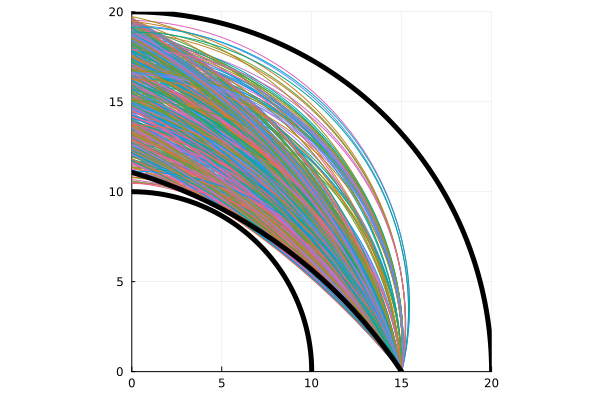

In [19]:
plot(tab3, tab4, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, ograniczenie_g),
     ylim=(0, ograniczenie_g), legend=false)
plot!(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
plot!(tab3[argmin(dl)], tab4[argmin(dl)], -pi, pi, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## ANIMACJA TRASY

[ Info: Saved animation to C:\Users\Aleksandra\OneDrive\Documents\PROGRAMOWANIE\Julia\Projekt_Pakiety_Matematyczne\tmp.gif


Plots.AnimatedGif("C:\\Users\\Aleksandra\\OneDrive\\Documents\\PROGRAMOWANIE\\Julia\\Projekt_Pakiety_Matematyczne\\tmp.gif")
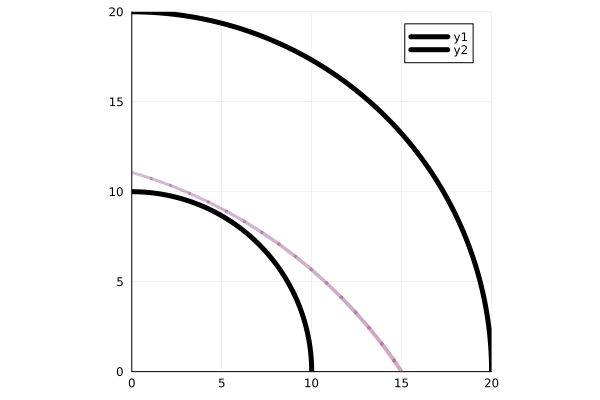

In [22]:
@userplot CirclePlot
@recipe function f(cp::CirclePlot)
    x, y, i = cp.args
    n = length(x)
    inds = circshift(1:n, 1 - i)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    x[inds], y[inds]
end

function animacja(num)
    n = 150
    t = range(-pi, π, length = n)
    y6 = r[num]*sin.(t) .+ y[num]
    x6 = r[num]*cos.(t) .+ x3[num] 
    
    anim = @animate for i ∈ 1:n
        circleplot!(x6, y6, i)
    end
    
    @gif for i ∈ 1:n
        plot(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
        circleplot!(x6, y6, i, line_z = 1:n, cbar = false, framestyle = :zerolines,  xlim=(0,20), ylim=(0, 20))
    end every 5
end

animacja(argmin(dl))

## GENEROWANIE NAJKRÓTSZYCH TRAS

In [ ]:
najkrotsze_trasy = []
promienie_najkrotszych_tras = []
czas = []

for i in 1:50
    dl = []
    generowanie_tras()
    push!(najkrotsze_trasy, dl[argmin(dl)])
    push!(promienie_najkrotszych_tras, r[argmin(dl)])
    push!(czas, dl[argmin(dl)]/10)
end

println("Średnia arytmetyczna najkrótszych długości tras: ", mean(najkrotsze_trasy))
zestawienie_najkrótszych_tras = DataFrame( DŁUGOŚĆ = najkrotsze_trasy, PROMIEŃ = promienie_najkrotszych_tras, CZAS = czas)

https://www.youtube.com/watch?v=KBXMan0Dafw